In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from numpy.linalg import inv

import statsmodels.api as sm
from course_1.risk_kit import Metrics
import nb.edhec_risk_kit_206 as erk
from backtesting import Backtester, EquallyWeighted, CapWeighted,\
GlobalMiminumVariance, EqualRiskContribution

import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.float_format = '{:.6f}'.format

m= Metrics()

In [2]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]

cov = ind_rets.cov()

In [3]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio,
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [4]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

In [28]:
risk_cw = risk_contribution(erk.weight_cw(ind_rets, ind_mcap), cov=cov)
risk_cw.idxmin(), risk_cw.min()
risk_cw.idxmax(), risk_cw.max()
(risk_cw.max() - risk_cw.min())*100

('Gold', 9.417069453030359e-05)

('Banks', 0.10396630266284636)

10.387213196831606

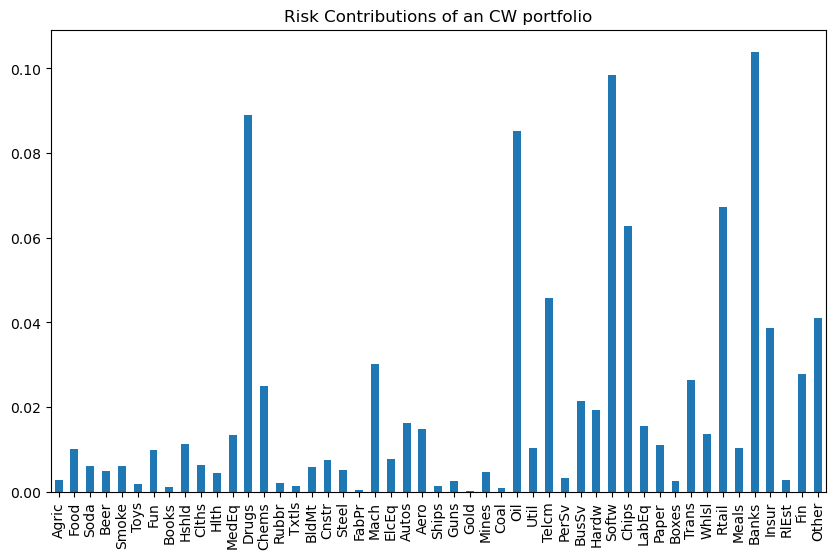

In [6]:
risk_cw.plot.bar(title="Risk Contributions of an CW portfolio");

In [27]:
risk_ew = risk_contribution(erk.weight_ew(ind_rets), cov)
risk_ew.idxmin(), risk_ew.min()
risk_ew.idxmax(), risk_ew.max()
(risk_ew.max() - risk_ew.min())*100

('Util', 0.005915906346269965)

('Steel', 0.030937663971181445)

2.502175762491148

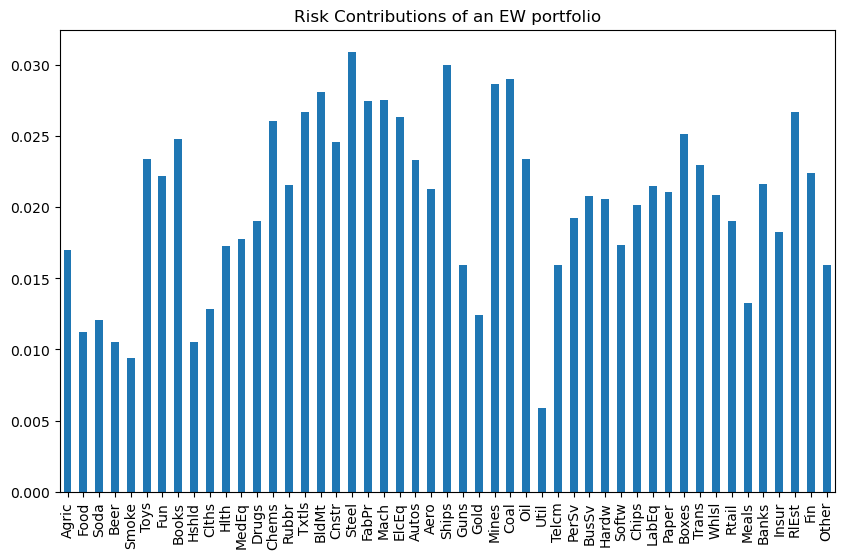

In [8]:
risk_ew.plot.bar(title="Risk Contributions of an EW portfolio");

In [23]:
w_erc = erk.weight_erc(ind_rets)
df_erc = pd.DataFrame(data=w_erc, index=ind_rets.columns, columns=["weight"])
df_erc.idxmax(), df_erc.max()

(weight    Util
 dtype: object,
 weight   0.052156
 dtype: float64)

In [24]:
df_erc.idxmin(), df_erc.min()

(weight    Steel
 dtype: object,
 weight   0.012809
 dtype: float64)

In [ ]:
risk_cw = risk_contribution(erk.weight_cw(ind_rets), cov)